# **Machine Learning using scikit-learn**

As a reminder, below are the following best practices we should follow when performing Machine Learning in Python:

1. Perform all pre-processing steps within cross-validation
2. Measure model performance (and model selection) using cross-validation
3. Follow literate programming practices to make code readable and make collaboration easier

## Problem Formulation

In this example, we will use IBM's HR Attrition dataset, available here: https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset.
The dataset contains data on 1470 employees. The variables covered in this dataset focus heavily on demographic attributes (e.g. gender, age and race), social related attributes (e.g. marital status) and work related attributes (e.g. tenure and pay).

In [77]:
#tables and visualizations
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn import config_context
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## Load Data

Here we first load the data into python using pandas and read it in as a pandas dataframe which is the format which we will use throughout the example. 

In [78]:
employee_df = pd.read_excel('IBM-HR-Data-Employee-Attrition.xlsx')
employee_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [79]:
employee_df.isna().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

## Data cleaning and EDA

We can now briefly explore our data. For now, we can observe that there are a zero NA values which will likely need imputation. We'll wait for this step so that we can put it within our training loop in case future data sets from IBM HR might have NA values. You are welcome to explore additional aspects of the data and build out 2-3 features on your own

In [80]:
employee_df = employee_df.dropna(subset=['Attrition'])
employee_df.shape

(1470, 35)

FEATURE ENGINEERING ONE

In [81]:
unit_percentage = (employee_df['MonthlyIncome'].max() - employee_df['MonthlyIncome'].min()) / 10
bins = [0, 1, 5, 10]
bin_values = [i*unit_percentage for i in bins]
employee_df['binned'] = pd.cut(employee_df['MonthlyIncome'], bin_values)
employee_df['binned'] = employee_df['binned'].apply(lambda x: f"{x.left:.0f}-cat-{x.right:.0f}")
employee_df['binned'] = employee_df['binned'].astype('object')
employee_df.info()
# By making it a string, the hot encoding in the pipeline wil automatically create a new column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

FEATURE ENGINEERING TWO

In [82]:
employee_df["tenure_to_promotion"] = employee_df["YearsAtCompany"] - employee_df["YearsInCurrentRole"]
print(employee_df["tenure_to_promotion"])



0       2
1       3
2       0
3       1
4       0
       ..
1465    3
1466    0
1467    4
1468    3
1469    1
Name: tenure_to_promotion, Length: 1470, dtype: int64


In [83]:
class_column = 'Attrition'
random_seed = 2435

X_train, X_test, y_train, y_test = train_test_split(employee_df.drop(columns=class_column), employee_df[class_column],
                                                   test_size=0.25, random_state=random_seed, stratify=employee_df[class_column])

Quick sanity check to make sure that everything seems correct:

In [84]:
# X Train
print('On X train: ')
print('X train dimensions: ', X_train.shape)
display(X_train.head())

# X test
print('\nOn X test: ')
print('X test dimensions: ', X_test.shape)
display(X_test.head())

On X train: 
X train dimensions:  (1102, 36)


,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,binned,tenure_to_promotion
1331,48,Travel_Rarely,1224,Research & Development,10,3,Life Sciences,1,1867,4,...,0,29,3,3,22,10,12,9,NaN,12
485,27,Travel_Rarely,798,Research & Development,6,4,Medical,1,655,1,...,2,6,5,2,5,3,0,3,1899-cat-9495,2
1368,34,Travel_Frequently,735,Research & Development,22,4,Other,1,1932,3,...,0,16,3,3,15,10,6,11,1899-cat-9495,5
579,34,Travel_Rarely,121,Research & Development,2,4,Medical,1,804,3,...,0,6,3,3,6,5,1,3,1899-cat-9495,1
142,38,Travel_Rarely,364,Research & Development,3,5,Technical Degree,1,193,4,...,0,19,2,3,3,2,2,2,1899-cat-9495,1



On X test: 
X test dimensions:  (368, 36)


,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,binned,tenure_to_promotion
129,49,Travel_Rarely,470,Research & Development,20,4,Medical,1,170,3,...,0,16,2,2,15,11,5,11,1899-cat-9495,4
1120,38,Travel_Rarely,437,Sales,16,3,Life Sciences,1,1583,2,...,0,8,5,4,3,2,1,2,1899-cat-9495,1
3,33,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,...,0,8,3,3,8,7,3,0,1899-cat-9495,1
965,25,Travel_Rarely,882,Research & Development,19,1,Medical,1,1358,4,...,3,7,6,2,3,2,1,2,1899-cat-9495,1
94,32,Travel_Rarely,1093,Sales,6,4,Medical,1,125,2,...,0,12,0,3,11,8,5,7,1899-cat-9495,3


In [85]:
# X Train
print('On y train: ')
print('y train dimensions: ', y_train.shape)
display(y_train.head())

# X test
print('\nOn y test: ')
print('y test dimensions: ', y_test.shape)
display(y_test.head())

On y train: 
y train dimensions:  (1102,)


1331    No
485     No
1368    No
579     No
142     No
Name: Attrition, dtype: object


On y test: 
y test dimensions:  (368,)


129     No
1120    No
3       No
965     No
94      No
Name: Attrition, dtype: object

## Establish the training pipeline

We can now establish the training pipeline for our models. Since this is a process we would need to repeat several times, it's good to essentially functionalize the process so we do not need to re-write redundant code. Here, we can impute some values that were missing, and encode any categorical values. Note that these pipelines will change according to the model and methodology you choose - additionally, the pipelines will also change depending on the data types of the columns in your dataset. 

In [86]:
# TODO: establish your own pipelines for the different data types
cat_pipeline = Pipeline(steps=[('cat_impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                               ('onehot_cat', OneHotEncoder(drop='if_binary'))])

num_pipeline = Pipeline(steps=[('impute_num', SimpleImputer(missing_values=np.nan, strategy='mean')),
                               ('scale_num', StandardScaler())])


In [87]:
# TODO: establish your preprocessing pipeline by your feature set

preproc = ColumnTransformer([('cat_pipe', cat_pipeline, make_column_selector(dtype_include=object)),
                             ('num_pipe', num_pipeline, make_column_selector(dtype_include=np.number))],
                             remainder='passthrough')


In [88]:
# TODO: set up your modeling pipeline


lr_pipe = Pipeline(steps=[('preproc', preproc),
                       ('mdl', LogisticRegression(penalty='elasticnet', solver='saga', tol=0.01))])

rf_pipe = Pipeline(steps=[('preproc', preproc),
                       ('mdl', RandomForestClassifier())])

gb_pipe = Pipeline(steps=[('preproc', preproc),
                       ('mdl', GradientBoostingClassifier())])
                       
# Feel free to uncomment and edit the code below to visualize your overall pieline
# with config_context(display='diagram'):
#     display(your_pipeline_name)

## Cross-validation with hyperparameter tuning

Now that we have our pipelines, we can now use this as part of cross validation and hyperparameter tuning.

In [89]:
# TODO: set up your tuning grid 
lr_grid = {
    'mdl__l1_ratio' : np.linspace(0,1,5),
    'mdl__C': np.logspace(-1, 6, 3) 
}

rf_grid = {
    'mdl__n_estimators' : [10, 50, 100],
    'mdl__max_depth' : [1, 5, 10],
}

gb_grid = {
    'mdl__n_estimators' : [10, 50, 100],
    'mdl__max_depth' : [1, 5, 10],
}

lr_search = GridSearchCV(lr_pipe, param_grid = lr_grid, cv = 5, return_train_score=True)
rf_search = GridSearchCV(rf_pipe, param_grid = rf_grid, cv = 5, return_train_score=True)
gb_search = GridSearchCV(gb_pipe, param_grid = gb_grid, cv = 5, return_train_score=True)


In [90]:
# TODO: fit your model

lr_search.fit(X_train, y_train)
# rf_search.fit(X_train, y_train)
# gb_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_pipe',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot_cat',
                                                                                          OneHotEncoder(drop='if_binary'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fdf267072e0>),
                                                                        ('num_pipe',
                                                                         Pipeline(step...
                                                                                          SimpleImputer()),
                                                                                         ('scale_num',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fdf26707850>)])),
                                       ('mdl',
                                        LogisticRegression(penalty='elasticnet',
                                                           solver='saga',
                                                           tol=0.01))]),
             param_grid={'mdl__C': array([1.00000000e-01, 3.16227766e+02, 1.00000000e+06]),
                         'mdl__l1_ratio': array([0.  , 0.25, 0.5 , 0.75, 1.  ])},
             return_train_score=True)

In [91]:
# TODO: find the best performing model parameters and their values

best_lr = lr_search.best_estimator_
# best_rf = rf_search.best_estimator_
# best_gb = gb_search.best_estimator_


## Final fit

The final fit here is already present in the generated model due to the way we set our parameters in the grid search. If we want to look at the performance, we can do so. Here is a non-helpful description of the best model:

In [92]:
# TODO: print your best estimator (pipeline)

print(best_lr)
# print(best_rf)
# print(best_gb)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdf267b5c10>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                

## Variable importance

Now we assess the importance in the selected model to reveal any potential insights.

In [93]:
def variable_importance(model):

    model.classes_

    vip = model['mdl'].coef_[0]
    vip

    #get names in correct preproc order
    cat_names = model.named_steps['preproc'].transformers_[0][1].named_steps['onehot_cat'].get_feature_names()
    num_names = model.named_steps['preproc'].transformers_[1][2]

    #create df with vip info
    coef_info = pd.DataFrame({'feat_names':np.hstack([cat_names, num_names]), 'vip': vip})

    #get sign and magnitude information
    coef_info = coef_info.assign(coef_mag = abs(coef_info['vip']),
                                 coef_sign = np.sign(coef_info['vip']))

    #sort and plot
    coef_info = coef_info.set_index('feat_names').sort_values(by='coef_mag', ascending=False)
    plt.figure(figsize = (20,10))
    sns.barplot(y=coef_info.index, x='coef_mag', hue='coef_sign', data=coef_info, orient='h', dodge=False)

/anaconda3/envs/CS-5262/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


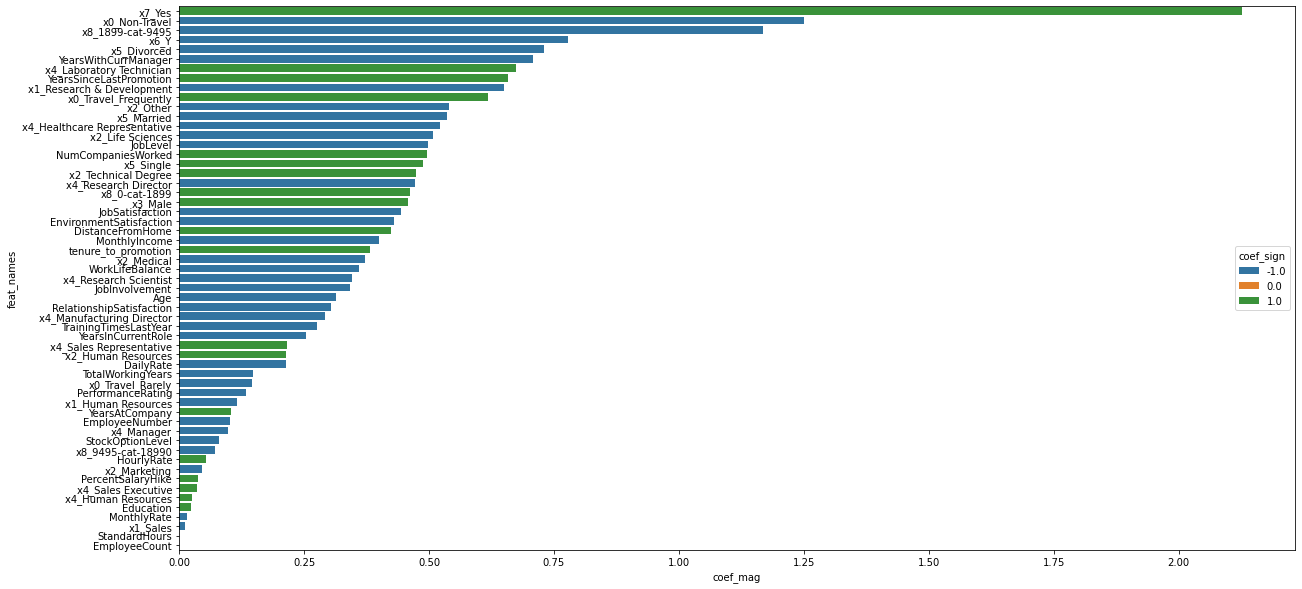

In [94]:
variable_importance(best_lr)
#variable_importance(best_rf)
#variable_importance(best_gb)

## Performance metrics on test data


Here, we can see the performance of the model, which is pretty nice! We can also look into different scores specifically for more insight into the performance.

In [95]:
# TODO: print your classification report of your model

def performance_metrics(model):

    print(classification_report(y_test, model.predict(X_test)))

    cm = confusion_matrix(y_test, model.predict(X_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()

              precision    recall  f1-score   support

          No       0.91      0.95      0.93       309
         Yes       0.65      0.51      0.57        59

    accuracy                           0.88       368
   macro avg       0.78      0.73      0.75       368
weighted avg       0.87      0.88      0.87       368



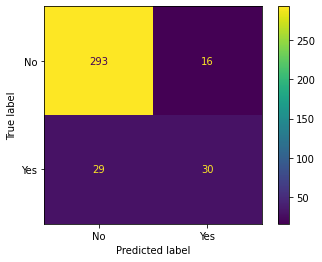

In [96]:

performance_metrics(best_lr)
# performance_metrics(best_rf)
# performance_metrics(best_gb)


In [28]:
def calculate_financial_value(model):

    cm = confusion_matrix(y_test, model.predict(X_test))
    tp = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tn = cm[1][1]

    # We are doing intervention on every person predicted to leave
    total_predicted_leave = tn + fn
    total_intervention_cost = total_predicted_leave * 2000

    # Intervention works on 20% of those who were actually going to leave
    decided_to_leave = int(tn * 0.8)

    # $120k for each person that decided to leave and intervention didn't work on
    replacement_cost = decided_to_leave * 120_000

    total_cost = total_intervention_cost + replacement_cost
    return total_cost

In [ ]:
print(f"Total cost of intervention LR model: ${calculate_financial_value(best_lr)}")
# print(f"Total cost of intervention RF model: ${calculate_financial_value(best_rf)}")
# print(f"Total cost of intervention GB model: ${calculate_financial_value(best_gb)}")

FEATURE PERFORMANCE ANALYSIS - Logistic Regression Model

Base with no extra features, LR model accuracy: 89%
With Feature Engineering One, LR model accuracy: 88%
With Feature Engineering Two, LR model accuracy: 88%
With Both Features, LR model accuracy: 88%

Most likley the accuracy decrease because the new feature engineering did not provide additional information that the model could not derive itself. Specifically, we already performed feature engineering in the regard of normalization and encoding. I've found in my experience, besides removing features all together, additional feature engineering is often negligible. 

TASK 1 FOR PERSONAL PROJECT

As with previous projects, signifigant work has already been completed on my first project, including a breadth of feature engineering. Thus, this section of the assignment has already been completed.